In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import tensorflow as tf
from tensorflow import keras

In [3]:
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
x_train = (x_train / 255.0) * 2 - 1
x_test = (x_test / 255.0) * 2 - 1
train_labels = keras.utils.to_categorical(y_train)
test_labels = keras.utils.to_categorical(y_test)

In [4]:
def create_discriminator(input_shape=(28, 28), num_classes=10):
    image_input = keras.layers.Input(shape=input_shape)
    label_input = keras.layers.Input(shape=(num_classes,))
    
    x = keras.layers.Flatten()(image_input)
    x = keras.layers.Concatenate(axis=1)([x, label_input])
    
    x = keras.layers.Dense(400, activation='relu')(x)
    x = keras.layers.Dropout(0.15)(x)
    x = keras.layers.Dense(200, activation='relu')(x)
    x = keras.layers.Dropout(0.15)(x)
    x = keras.layers.Dense(100, activation='relu')(x)
    x = keras.layers.Dropout(0.15)(x)
    output = keras.layers.Dense(1, activation='relu')(x)
    
    model = keras.models.Model(
        inputs=[image_input, label_input], 
        outputs=[output],
        name='discriminator'
    )

    return model

In [5]:
def create_generator(latent_dim=100, num_classes=10):
    noise_input = keras.layers.Input(shape=(latent_dim,))
    label_input = keras.layers.Input(shape=(num_classes,))
    
    x = keras.layers.Concatenate(axis=1)([noise_input, label_input])
    
    x = keras.layers.Dense(200, activation="relu")(x)
    x = keras.layers.Dense(400, activation="relu")(x)
    x = keras.layers.Dense(784, activation="tanh")(x)
    output = keras.layers.Reshape((28, 28))(x)
    
    model = keras.models.Model(
        inputs=[noise_input, label_input],
        outputs=[output],
        name='generator'
    )

    return model

In [6]:
def conditional_gan(generator, discriminator):
    noise_input = keras.layers.Input(shape=(100,))
    label_input = keras.layers.Input(shape=(10,))
    
    generated_image = generator([noise_input, label_input])
    discriminator.trainable = False
    validity = discriminator([generated_image, label_input])
    
    model = keras.models.Model(
        inputs=[noise_input, label_input],
        outputs=[validity],
        name='conditional_gan'
    )

    return model

In [7]:
def visualize_generated_images(generator, num_classes=10, samples_per_class=10):
    labels = keras.utils.to_categorical(
        [i for j in range(num_classes) for i in range(samples_per_class)]
    )
    noise = np.random.normal(0, 1, (num_classes * samples_per_class, 100))
    
    generated_images = generator.predict([noise, labels])
    generated_images = generated_images * 0.5 + 0.5  # Rescale to [0, 1]
    
    fig, axes = plt.subplots(num_classes, samples_per_class, figsize=(8, 8))
    for i in range(num_classes):
        for j in range(samples_per_class):
            axes[i, j].imshow(
                generated_images[i * samples_per_class + j].reshape((28, 28)),
                cmap='binary'
            )
            axes[i, j].axis('off')
    plt.show()

In [8]:
discriminator = create_discriminator()
generator = create_generator()
gan = conditional_gan(generator, discriminator)

2024-12-03 19:26:52.520138: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2024-12-03 19:26:52.520176: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2024-12-03 19:26:52.520187: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2024-12-03 19:26:52.520425: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-12-03 19:26:52.520818: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [9]:
discriminator.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    loss='binary_crossentropy',
    metrics=['accuracy']
)
discriminator.summary()

Model: "discriminator"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 28, 28)]             0         []                            
                                                                                                  
 flatten (Flatten)           (None, 784)                  0         ['input_1[0][0]']             
                                                                                                  
 input_2 (InputLayer)        [(None, 10)]                 0         []                            
                                                                                                  
 concatenate (Concatenate)   (None, 794)                  0         ['flatten[0][0]',             
                                                                     'input_2[0][0]'] 

In [10]:
gan.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    loss='binary_crossentropy',
    metrics=['accuracy']
)
gan.summary()

Model: "conditional_gan"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 100)]                0         []                            
                                                                                                  
 input_6 (InputLayer)        [(None, 10)]                 0         []                            
                                                                                                  
 generator (Functional)      (None, 28, 28)               416984    ['input_5[0][0]',             
                                                                     'input_6[0][0]']             
                                                                                                  
 discriminator (Functional)  (None, 1)                    418401    ['generator[0][0

In [11]:
def generate_random_input(size, latent_dim=100):
    noise = np.random.normal(0, 1, (size, latent_dim))
    random_indices = np.random.choice(10000, size)
    random_tags = train_labels[random_indices]
    return noise, random_tags

In [12]:
def train_discriminator(discriminator, generator, real_images, real_tags):
    batch_size = len(real_images)
    discriminator.trainable = True
    loss_real, acc_real = discriminator.train_on_batch(
        [real_images, real_tags],
        np.ones((batch_size, 1)))
    noise, fake_tags = generate_random_input(batch_size)
    fake_images = generator.predict([noise, fake_tags])
    loss_fake, acc_fake = discriminator.train_on_batch(
        [fake_images, fake_tags],
        np.zeros((batch_size, 1)))
    return (loss_real + loss_fake) / 2.0, acc_real, acc_fake

In [13]:
def train_generator(gan, discriminator, batch_size):
    discriminator.trainable = False
    noise, random_tags = generate_random_input(batch_size)
    return gan.train_on_batch(
        [noise, random_tags],
        np.ones((batch_size, 1)))

In [14]:
def train_gan(generator, discriminator, gan, train_images, train_labels, 
              batch_size=1000, epochs=100):
    metrics = {
        'acc_real': [],
        'acc_fake': [],
        'loss_disc': [],
        'loss_gen': []
    }
    
    for epoch in range(epochs):
        for batch_start in range(0, train_images.shape[0], batch_size):
            batch_end = batch_start + batch_size
            real_batch = train_images[batch_start:batch_end, :]
            real_batch_tags = train_labels[batch_start:batch_end, :]
            
            disc_loss, real_acc, fake_acc = train_discriminator(
                discriminator, 
                generator,
                real_batch, 
                real_batch_tags)
            
            gen_loss = train_generator(gan, discriminator, batch_size)
            
            metrics['acc_real'].append(real_acc)
            metrics['acc_fake'].append(fake_acc)
            metrics['loss_disc'].append(disc_loss)
            metrics['loss_gen'].append(gen_loss)
    
    return metrics

In [18]:
metrics = train_gan(generator, discriminator, gan, train_images, train_labels)

2024-12-03 00:13:34.629672: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 1s 13ms/step


2024-12-03 00:13:36.284242: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Adam/AssignAddVariableOp.


32/32 [==============================] - 0s 1ms/step
Epoch:  0 , Acc Real:  0.5849999785423279 , Acc Fake:  0.5899999737739563 , D-Loss:  4.800978660583496 , G-Loss:  [6.593208312988281, 0.41999998688697815]
32/32 [==============================] - 0s 2ms/step
Epoch:  50 , Acc Real:  0.5849999785423279 , Acc Fake:  0.06700000166893005 , D-Loss:  9.425681829452515 , G-Loss:  [0.8445851802825928, 0.9240000247955322]
32/32 [==============================] - 0s 1ms/step


In [15]:
acc_real = metrics['acc_real']
acc_fake = metrics['acc_fake']

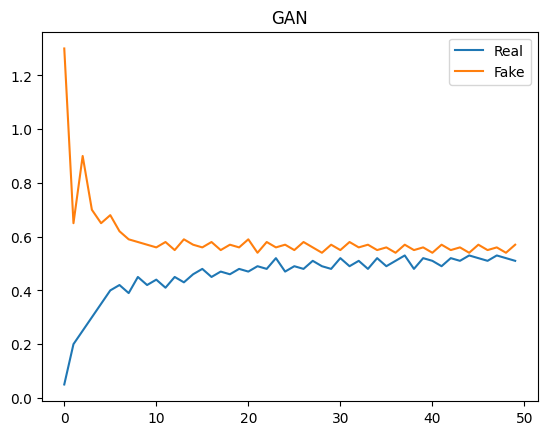

In [16]:
plt.plot(acc_real, label="Real")
plt.plot(acc_fake, label="Fake")
plt.title("GAN")
plt.legend()  
plt.show()

4/4 [==============================] - 1s 116ms/step


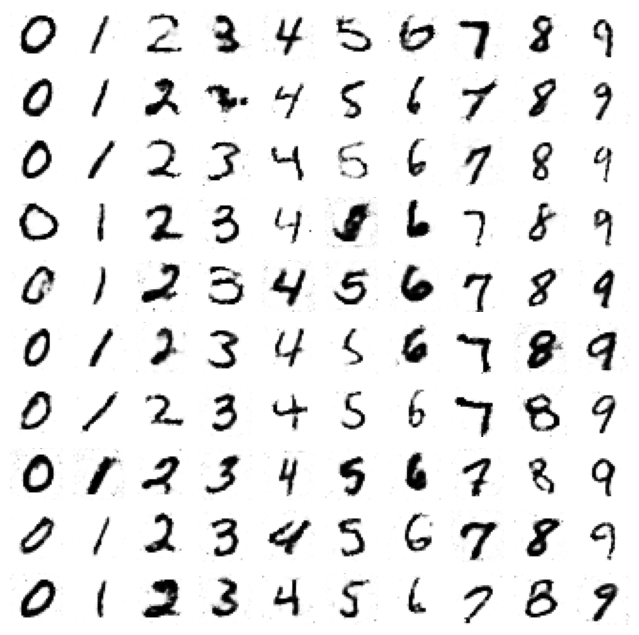

In [24]:
visualize_generated_images(generator)